(1018, 1536)
884
[299, 497]
(500, 300)
(500, 300)
14


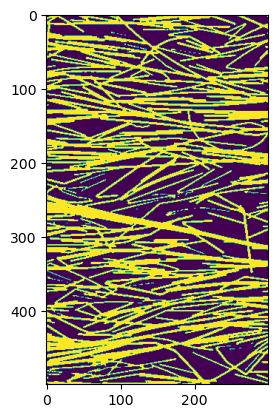

IndexError: index 400 is out of bounds for axis 1 with size 300

In [25]:
img = cv.imread('TestData/AgNWN_10um/10um.tif',cv.IMREAD_GRAYSCALE)
print(img.shape)
print(f.Gr.ecount())
print(f.shape)
print(f.img_bin.shape)
print(f.skeleton.shape)
print(sum(f.edge_weights==1))
plt.imshow(f.img_bin)
plt.show()
f.img_bin[200,400]

In [20]:
#Draft
import numpy as np
import igraph as ig
import os
import cv2 as cv
import base
import process_image
import json
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import error
import time
import functools
import gsd.hoomd
from skimage.morphology import skeletonize_3d
import pandas as pd

class Network():
    """Generic SGT graph class: a specialised case of the igraph Graph object with 
    additional attributes defining geometric features, associated images,
    dimensionality etc.
    
    Initialised from directory containing raw image data
    self._2d determined from the number of images with identical dimensions (suggesting a stack when > 1)
    
    Image shrinking/cropping is carried out at the gsd stage in analysis.
    I.e. full images are binarized but cropping their graphs may come after
    """
    def __init__(self, directory, child_dir='/Binarized'):
        if not isinstance(directory, str):
            raise TypeError
            
        self.dir = directory
        self.child_dir = child_dir
        self.stack_dir = self.dir + self.child_dir
        
        shape = []
        for name in sorted(os.listdir(self.dir)):
            if not base.Q_img(name):
                continue
            shape.append(cv.imread(self.dir+'/'+name,cv.IMREAD_GRAYSCALE).shape)
        
        if len(set(shape)) == len(shape):
            self._2d = True
            self.dim = 2
        else:
            self._2d = False
            self.dim = 3
        
    def binarize(self, options_dict=None):
        """Binarizes stack of experimental images using a set of image processing parameters in options_dict.
        Note this enforces that all images have the same shape as the first image encountered by the for loop.
        (i.e. the first alphanumeric titled image file)
        """
        
        if options_dict is None:
            options = self.dir + '/img_options.json'
            with open(options) as f:
                options_dict = json.load(f)

        if not os.path.isdir(self.dir + self.child_dir):
            os.mkdir(self.dir + self.child_dir)

        i=0
        for name in sorted(os.listdir(self.dir)):
            if not base.Q_img(name):
                continue
            else:
                img_exp = cv.imread(self.dir+'/'+name,cv.IMREAD_GRAYSCALE)
                if i == 0: shape = img_exp.shape
                elif img_exp.shape != shape: continue
                _, img_bin, _ = process_image.binarize(img_exp, options_dict)
                plt.imsave(self.dir+self.child_dir+'/slice'+str(i)+'.tiff', img_bin, cmap=cm.gray)
                i+=1
        
    def stack_to_gsd(self, name='skel.gsd', crop=None, skeleton=True, rotate=None, debubble=None):
        """Writes a .gsd file from the object's directory.
        The name of the written .gsd is set as an attribute so it may be easily matched with its Graph object 
        Running this also sets the positions, shape attributes
        
        """
        
        start = time.time()
        self.gsd_name = self.stack_dir + '/' + name
        self.gsd_dir = os.path.split(self.gsd_name)[0]
        img_bin=[]
        
        #Initilise i such that it starts at the lowest number belonging to the images in the stack_dir
        #First require boolean mask to filter out non image files
        olist = np.asarray(sorted(os.listdir(self.stack_dir)))
        mask = list(base.Q_img(olist[i]) for i in range(len(olist)))
        if len(mask) == 0:
            raise error.ImageDirectoryError(self.stack_dir)
        fname = sorted(olist[mask])[0] #First name
        i = int(os.path.splitext(fname)[0][5:]) #Strip file type and 'slice' then convert to int
        
        #Generate 3d (or 2d) array from stack
        for fname in sorted(os.listdir(self.stack_dir)):
            if base.Q_img(fname):
                img_slice = cv.imread(self.stack_dir+'/slice'+str(i)+'.tiff',cv.IMREAD_GRAYSCALE)
                if rotate is not None:
                    image_center = tuple(np.array(img_slice.shape[1::-1]) / 2)
                    rot_mat = cv.getRotationMatrix2D(image_center, rotate, 1.0)
                    img_slice = cv.warpAffine(img_slice, rot_mat, img_slice.shape[1::-1], flags=cv.INTER_LINEAR)
                img_bin.append(img_slice)
                i=i+1
            else:
                continue
        
        #For 2D images, img_bin_3d.shape[0] == 1
        img_bin = np.asarray(img_bin)
        self.img_bin_3d = img_bin
        self.img_bin = img_bin
        
        #Note that numpy array slicing operations are carried out in reverse order!
        #(...hence crop 2 and 3 before 0 and 1)
        if crop and self._2d:
            self.img_bin = self.img_bin[:, crop[2]:crop[3], crop[0]:crop[1]]
            #img_bin = img_bin[crop[0]:crop[1], crop[2]:crop[3]]
        elif crop:
            #TODO figure tf this bit out
            self.img_bin = self.img_bin[crop[0]:crop[1], crop[2]:crop[3], crop[4]:crop[5]]
        
        assert self.img_bin_3d.shape[1] > 1
        assert self.img_bin_3d.shape[2] > 1
              
        #img_bin = np.asarray([img_slice])
        #img_bin = np.swapaxes(img_bin, 0, 2)
        self.img_bin_3d = self.img_bin            #Always 3d, even for 2d images
        self.img_bin = np.squeeze(self.img_bin)   #3d for 3d images, 2d otherwise
        
        if skeleton:
            self.skeleton = skeletonize_3d(np.asarray(self.img_bin))
            self.skeleton_3d = skeletonize_3d(np.asarray(self.img_bin_3d))
        else:
            self.img_bin = np.asarray(self.img_bin)
        
        positions = np.asarray(np.where(np.asarray(self.skeleton_3d) == 255)).T
        self.shape = np.asarray(list(max(positions.T[i])+1 for i in (0,1,2)))
        self.positions = positions
        
        print(positions)
        print(self.img_bin.shape)
        
        with gsd.hoomd.open(name=self.gsd_name, mode='wb') as f:
            s = gsd.hoomd.Snapshot()
            s.particles.N = len(positions)
            s.particles.position = base.shift(positions)
            s.particles.types = ['A']
            s.particles.typeid = ['0']*s.particles.N
            f.append(s)
        
        end = time.time()
        print('Ran stack_to_gsd() in ', end-start, 'for gsd with ', len(positions), 'particles')
        
        if debubble is not None: self = TEMPdebubble(self, debubble)
            
        assert g.img_bin.shape == g.skeleton.shape
        assert g.img_bin_3d.shape == g.skeleton_3d.shape
        
    def G_u(self):
        """Sets unweighted igraph object as an attribute
        """
        G =  base.gsd_to_G(self.gsd_name, _2d = self._2d)
        self.Gr = G
        self.shape = list(max(list(self.Gr.vs[i]['o'][j] for i in range(self.Gr.vcount()))) for j in (0,1,2)[0:self.dim])
        
    def weighted_Laplacian(self):

        L=np.asarray(self.Gr.laplacian(weights='weight'))
        self.L = L

class ResistiveNetwork(Network):
    """Child of generic SGT Network class.
    Equipped with methods for analysing resistive flow networks

    """
    def __init__(self, directory):
        super().__init__(directory)
        
    def potential_distribution(self, plane, boundary1, boundary2, R_j=0, rho_dim=1, F_dim=1):
        """Solves for the potential distribution in a weighted network.
        Source and sink nodes are connected according to a penetration boundary condition.
        Sets the corresponding weighted Laplacian, potential and flow attributes.
        The 'plane' arguement defines the axis along which the boundary arguements refer to.
        R_j='infinity' enables the unusual case of all edges having the same unit resistance.
        """
        self.Gr = base.sub_G(self.Gr)
        print('post sub has ', self.Gr.vcount(), ' nodes')
        if R_j != 'infinity':
            print(self.Gr.vcount())
            self.Gr = base.add_weights(self, weight_type='Resistance', R_j=R_j, rho_dim=rho_dim)
            print(self.Gr.vcount())
            weight_array = np.asarray(self.Gr.es['weight']).astype(float)
            weight_array = weight_array[~np.isnan(weight_array)]
            self.edge_weights = weight_array
            weight_avg =np.mean(weight_array)
        else:
            self.Gr.es['weight'] = np.ones(self.Gr.ecount())
            weight_avg = 1

        #Add source and sink nodes:
        source_id = max(self.Gr.vs).index + 1
        sink_id = source_id + 1
        self.Gr.add_vertices(2)

        print('Graph has max ', self.shape)
        axes = np.array([0,1,2])[0:self.dim]
        indices = axes[axes!=plane]
        plane_centre1 = np.zeros(self.dim, dtype=int)
        delta = np.zeros(self.dim, dtype=int)
        delta[plane] = 10 #Arbitrary. Standardize?
        for i in indices: plane_centre1[i] = self.shape[i]/2
        plane_centre2 = np.copy(plane_centre1)
        plane_centre2[plane] = self.shape[plane]
        source_coord = plane_centre1 - delta 
        sink_coord = plane_centre2 + delta
        print('source coord is ', source_coord)
        print('sink coord is ', sink_coord)
        self.Gr.vs[source_id]['o'] = source_coord
        self.Gr.vs[sink_id]['o'] = sink_coord

    #Connect nodes on a given boundary to the external current nodes
        print('Before connecting external nodes, G has vcount ', self.Gr.vcount())
        for node in self.Gr.vs:
            if node['o'][plane] > boundary1[0] and node['o'][plane] < boundary1[1]:
                self.Gr.add_edges([(node.index, source_id)])
                self.Gr.es[self.Gr.get_eid(node.index,source_id)]['weight'] = weight_avg
                self.Gr.es[self.Gr.get_eid(node.index,source_id)]['pts'] = base.connector(source_coord,node['o'])
            if node['o'][plane] > boundary2[0] and node['o'][plane] < boundary2[1]:
                self.Gr.add_edges([(node.index, sink_id)])
                self.Gr.es[self.Gr.get_eid(node.index,sink_id)]['weight'] = weight_avg 
                self.Gr.es[self.Gr.get_eid(node.index,sink_id)]['pts'] = base.connector(sink_coord,node['o'])

    #Write skeleton connected to external node
        print(self.Gr.is_connected(), ' connected')
        print('After connecting external nodes, G has vcount ', self.Gr.vcount())
        connected_name = os.path.split(self.gsd_name)[0] + '/connected_' + os.path.split(self.gsd_name)[1] 
        #connected_name = self.stack_dir + '/connected_' + self.gsd_name 
        base.G_to_gsd(self.Gr, connected_name)

        self.weighted_Laplacian()
        F = np.zeros(sink_id+1)
        print(F.shape,'F')
        print(self.L.shape, 'L')
        F[source_id] = F_dim
        F[sink_id] = -F_dim
        np.save(self.stack_dir+'/L.npy',self.L)
        np.save(self.stack_dir+'/F.npy',F)
        P = np.matmul(np.linalg.pinv(self.L, hermitian=True),F)
        np.save(self.stack_dir+'/P.npy',P)

        self.P = P
        self.F = F

class StructuralNetwork(Network):
    """Child of generic SGT Network class.
    Equipped with methods for analysing structural networks
    """
    def __init__(self, directory):
        super().__init__(directory)
        
    def G_calc(self):
        avg_indices = dict()

        operations = [self.Gr.diameter, self.Gr.density, self.Gr.transitivity_undirected, self.Gr.assortativity_degree]
        names = ['Diameter', 'Density', 'Clustering', 'Assortativity by degree']

        for operation,name in zip(operations,names):
            start = time.time()
            avg_indices[name] = operation()
            end = time.time()
            print('Calculated ', name, ' in ', end-start)
            
        self.G_attributes = avg_indices
        
    def node_calc(self):
        self.Betweenness = self.Gr.betweenness()
        self.Closeness = self.Gr.closeness()
        self.Degree = self.Gr.degree()

In [2]:
def TEMPdebubble(g, elements):
    if not isinstance(elements,list): raise error.StructuralElementError
        
    start = time.time()
    g.gsd_name = g.gsd_dir + '/debubbled_' + os.path.split(g.gsd_name)[1]
    
    canvas = g.img_bin
    for elem in elements:
        canvas = skeletonize_3d(canvas)/255
        canvas = binary_closing(canvas, selem=elem)

    g.skeleton = skeletonize_3d(canvas)/255

    if g._2d:
        g.skeleton_3d = np.swapaxes(np.array([g.skeleton]), 0, 1)
        g.skeleton_3d = np.swapaxes(np.array([g.skeleton]), 2, 1)
    else:
        g.skeleton_3d = g.skeleton
      
    positions = np.asarray(np.where(g.skeleton_3d!=0)).T
    positions = base.shift(positions)
    with gsd.hoomd.open(name=g.gsd_name, mode='wb') as f:
        s = gsd.hoomd.Snapshot()
        s.particles.N = int(sum(g.skeleton_3d.ravel()))
        s.particles.position = positions 
        s.particles.types = ['A']
        s.particles.typeid = ['0']*s.particles.N
        f.append(s)
    end = time.time()
    print('Ran debubble in ', end-start, 'for an image with shape ', g.skeleton_3d.shape)
    
    return g

NameError: name 'g' is not defined

In [21]:
"""Examples:
f = ResistiveNetwork('TestData/AgNWN_10um')
f.binarize()
f.stack_to_gsd(crop=[300,600,0,500], debubble=[disk(3)])
f.G_u()
f.potential_distribution(1, [0,20], [480,500])
base.Node_labelling(f, f.P, 'P', 'test1.gsd')

g = ResistiveNetwork('TestData/pores-hi-res-crop')
g.stack_to_gsd(crop=[0,100,0,100,0,100], debubble=[ball(3)])
g.G_u()
g.potential_distribution(0, [0,20], [80,100])
base.Node_labelling(g, g.P, 'P', 'test2.gsd')

s = StructuralNetwork('TestData/fibres-hi-res-crop')
s.stack_to_gsd(crop=[0,100,0,100,0,100])
s.G_u()
s.node_calc()
base.Node_labelling(s, s.Degree, 'Degree', 'test3.gsd')
"""
f = ResistiveNetwork('TestData/AgNWN_10um')
f.binarize()
f.stack_to_gsd(crop=[300,600,0,500], debubble=[disk(3)])
f.G_u()
f.potential_distribution(1, [0,20], [480,500])
base.Node_labelling(f, f.P, 'P', 'test1.gsd')

[[  0   0 143]
 [  0   0 144]
 [  0   0 146]
 ...
 [  0 499 194]
 [  0 499 195]
 [  0 499 196]]
(500, 300)
Ran stack_to_gsd() in  0.05599403381347656 for gsd with  17181 particles
(500, 300) dedq
Ran debubble in  0.07192611694335938 for an image with shape  (1, 300, 500)
gsd_to_G canvas has shape  (300, 500)
[[ 0 72]]
(0, 54, array([[ 0, 72],
       [ 1, 72],
       [ 2, 71],
       [ 3, 71],
       [ 4, 71],
       [ 5, 71],
       [ 6, 71],
       [ 7, 71],
       [ 8, 70],
       [ 9, 71],
       [10, 71],
       [11, 72],
       [12, 73],
       [12, 74],
       [13, 75],
       [13, 76],
       [13, 77]], dtype=int16))
Ran gsd_to_G in  0.481762170791626 for a graph with  681 nodes.
pre sub has  681  nodes
post sub has  631  nodes
post sub has  631  nodes
631
graph_shape is  [299, 497]  and img_shape is  (1, 500, 300)
Loaded img in  0.0
img_bin has shape  (500, 300)
Added weights to a graph  with  631 nodes in  0.07481598854064941
631
Graph has max  [299, 497]
source coord is  [149

implicit data copy when writing chunk: log/particles/P


In [4]:
#Rotation test
#Continuous rotation analysis
#Testing base.py implementation
#This implementation rotates the image itself

#######################################################
## USE THIS CELL FOR TESTING THE ABOVE DECLARATIONS ##
## USE A SEPARATE NOTEBOOK FOR TESTING network.py   ##
#######################################################

from PIL import Image
from skimage.morphology import binary_closing, disk, ball, skeletonize_3d
g = ResistiveNetwork('TestData/AgNWN_10um')
g.binarize()

#thetas = np.linspace(0.001,350, 4)
thetas = (0,45,110,90)

#crop = 359

#Need to reassign weights from a temporary rotated binary image
#First write the temporary image
#Must calculate positions for the crop because this crop is origin cornered (and not origin centred, like the one above)
img_bin = cv.imread(g.stack_dir+'/slice0.tiff') #Original image
image_center = tuple(np.array(img_bin.shape[1::-1]) / 2)
short_length = img_bin.shape[img_bin.shape == max(img_bin.shape)]
long_length = max(img_bin.shape)
ISS = (short_length**2/2)**0.5
L1 = int((long_length - ISS)/2)
L3 = int(ISS+L1)
L2 = int((short_length - ISS)/2)
L4 = int(ISS+L2)
o_corn_crop = [L2,L1,L4,L3]
dims = L2-L1



R_j = 0
O_eff_df = []
Ax_df = []
Ay_df = []
theta_df = []
nodes = []
for theta in thetas:
    g.stack_to_gsd(name='/Rotations/ObjectImplementation/rot_skel.gsd', crop=[L1,L3,L2,L4], rotate=theta, debubble=[disk(2)])
    g.G_u()
    g.potential_distribution(0, [0,20], [727-20,727], R_j=R_j, rho_dim=0.89, F_dim=1)
    base.Node_labelling(g, g.P, 'P', 'take2.gsd')
    #Ax, Ay = base.gyration_moments(g.Gr, sampling = 0.1)
    #L = g.L
    #Q = np.linalg.pinv(L)
    #O_eff = Q[-1,-1]+Q[-2,-2]-2*Q[-1,-2]
    
    nodes.append(g.Gr.vcount())
    df_cont = pd.DataFrame(columns=['Theta','O_eff','Ax','Ay'])
    df_cont['O_eff'] = O_eff_df
    df_cont['Ax'] = Ax_df
    df_cont['Ay'] = Ay_df
    df_cont['Theta'] = theta_df
    #df_cont.to_csv('AgNWN.csv')

    df_cont
    #print(theta, O_eff, Ax, Ay)
    
    #stop
    
    
    #O_eff_df.append(O_eff)
    #Ax_df.append(Ax)
    #Ay_df.append(Ay)
    #theta_df.append(theta)



[[  0   0   4]
 [  0   0   5]
 [  0   0   6]
 ...
 [  0 718 673]
 [  0 718 674]
 [  0 718 675]]
(719, 719)
Ran stack_to_gsd() in  0.19238901138305664 for gsd with  59554 particles
(719, 719) dedq
Ran debubble in  0.23460698127746582 for an image with shape  (1, 719, 719)
gsd_to_G canvas has shape  (719, 719)
[[0 1]]
(0, 142, array([[ 0,  1],
       [ 1,  1],
       [ 2,  1],
       [ 3,  1],
       [ 4,  0],
       [ 5,  0],
       [ 6,  0],
       [ 7,  0],
       [ 8,  0],
       [ 9,  1],
       [10,  1],
       [11,  1],
       [12,  2],
       [13,  2],
       [14,  3],
       [15,  3],
       [16,  3],
       [17,  3],
       [18,  3],
       [19,  3],
       [20,  3],
       [21,  4],
       [22,  4],
       [23,  4],
       [24,  3],
       [25,  3],
       [26,  3],
       [27,  3],
       [28,  3],
       [29,  2],
       [30,  2]], dtype=int16))
Ran gsd_to_G in  1.8763439655303955 for a graph with  2653 nodes.
pre sub has  2653  nodes
post sub has  2273  nodes
post sub has  

implicit data copy when writing chunk: log/particles/P


[[  0   0  14]
 [  0   0  27]
 [  0   0 199]
 ...
 [  0 718 659]
 [  0 718 660]
 [  0 718 671]]
(719, 719)
Ran stack_to_gsd() in  0.2756338119506836 for gsd with  57962 particles
(719, 719) dedq
Ran debubble in  0.2588469982147217 for an image with shape  (1, 719, 719)
gsd_to_G canvas has shape  (719, 719)
[[0 1]]
(1, 22, array([[  0, 156],
       [  0, 155],
       [  1, 154],
       [  1, 153],
       [  2, 152]], dtype=int16))
Ran gsd_to_G in  1.8098831176757812 for a graph with  3135 nodes.
pre sub has  3135  nodes
post sub has  2888  nodes
post sub has  2888  nodes
2888
graph_shape is  [718, 718]  and img_shape is  (1, 719, 719)
Loaded img in  0.0
img_bin has shape  (719, 719)
Added weights to a graph  with  2888 nodes in  0.4607093334197998
2888
Graph has max  [718, 718]
source coord is  [-10 359]
sink coord is  [728 359]
Before connecting external nodes, G has vcount  2890
True  connected
After connecting external nodes, G has vcount  2890
(2890,) F
(2890, 2890) L


implicit data copy when writing chunk: log/particles/P


[[  0   0 162]
 [  0   0 290]
 [  0   0 359]
 ...
 [  0 718 668]
 [  0 718 701]
 [  0 718 702]]
(719, 719)
Ran stack_to_gsd() in  0.23226594924926758 for gsd with  63247 particles
(719, 719) dedq
Ran debubble in  0.2490980625152588 for an image with shape  (1, 719, 719)
gsd_to_G canvas has shape  (719, 719)


KeyboardInterrupt: 

In [ ]:
len(np.asarray(np.where(np.asarray(g.img_bin_3d)!=0)).T)

In [ ]:
dir(error)

In [ ]:
g.img_bin_3d
img_bin = np.swapaxes(g.img_bin_3d, 0, 2)

crop = o_corn_crop
img_bin[crop[2]:crop[3], crop[0]:crop[1]].shape

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(thetas,nodes)
plt.show()

In [ ]:

img_bin=[]
img_bin.append(img_slice)
img_bin = np.asarray(img_bin)
img_bin = np.swapaxes(img_bin, 0, 2)
print(img_bin.shape)
img_bin = img_bin[crop[2]:crop[3],crop[0]:crop[1]]
print(img_bin.shape)

In [ ]:
def timer(_class,method):
    """Print the runtime of the decorated function"""
    @functools.wraps(method)
    def wrapper_timer(*args, **kwargs):
        start_time = time.perf_counter()    # 1
        value = _method(*args, **kwargs)
        end_time = time.perf_counter()      # 2
        run_time = end_time - start_time    # 3
        print(f"Finished {method.__name__!r} in {run_time:.4f} secs")
        print(_class)
        print(method)
        return value
    return wrapper_timer